# Regularization techniques

In [5]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# Regularization in statistics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Data generation (10-D)
# -----------------------------
np.random.seed(42)

n_train = 30
n_test = 200
d = 10

# Ground-truth weights: sparse-ish with mixed signs
true_w = np.array([2.5, -1.7, 0.0, 0.0, 1.2, 0.0, 0.0, -0.5, 0.0, 0.8])
true_b = 0.5
noise_sigma = 1.0

X_train = np.random.randn(n_train, d)
X_test  = np.random.randn(n_test, d)

y_train = X_train @ true_w + true_b + np.random.normal(scale=noise_sigma, size=n_train)
y_test  = X_test  @ true_w + true_b + np.random.normal(scale=noise_sigma, size=n_test)

# Add intercept column as LAST column (will NOT be regularized)
Xtr = np.hstack([X_train, np.ones((n_train, 1))])
Xte = np.hstack([X_test,  np.ones((n_test, 1))])

# -----------------------------
# 2) Ridge closed-form (no reg on intercept)
# -----------------------------
def ridge_regression(X, y, alpha):
    """Return w including intercept as the last element.
    Intercept column is assumed to be the last column of X and is NOT regularized.
    """
    p = X.shape[1]
    I = np.eye(p)
    I[-1, -1] = 0.0  # do not regularize the intercept
    return np.linalg.inv(X.T @ X + alpha * I) @ (X.T @ y)

def mse(y_true, y_pred):
    return float(np.mean((y_true - y_pred) ** 2))

# -----------------------------
# 3) Fit for α=0 and a grid of α>0
# -----------------------------
alphas_grid = np.logspace(-3, 3, 60)   # α > 0 for smooth log plot
alpha0 = 0.0

# α = 0 (ordinary least squares)
w0 = ridge_regression(Xtr, y_train, alpha0)
ytr0 = Xtr @ w0
yte0 = Xte @ w0
mse_tr_0 = mse(y_train, ytr0)
mse_te_0 = mse(y_test,  yte0)

# α > 0
weights_grid = []
mse_tr_grid = []
mse_te_grid = []
for a in alphas_grid:
    w = ridge_regression(Xtr, y_train, a)
    weights_grid.append(w)
    mse_tr_grid.append(mse(y_train, Xtr @ w))
    mse_te_grid.append(mse(y_test,  Xte @ w))

weights_grid = np.asarray(weights_grid)
mse_tr_grid = np.asarray(mse_tr_grid)
mse_te_grid = np.asarray(mse_te_grid)

# Best alpha on test (for demo; in practice use val/CV)
best_idx = int(np.argmin(mse_te_grid))
best_alpha = float(alphas_grid[best_idx])
best_test_mse = float(mse_te_grid[best_idx])

# Also keep a few representative alphas for the weight plot
alphas_show = [0, 1, 10, 50]
weights_show = []
for a in alphas_show:
    w = ridge_regression(Xtr, y_train, a)
    weights_show.append(w)
weights_show = np.asarray(weights_show)

# -----------------------------
# 4) Plots
# -----------------------------
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
fig = plt.figure(figsize=(12, 5))

# (A) Weight trajectories for selected alphas
ax1 = fig.add_subplot(1, 2, 1)
dims = np.arange(1, d + 1)
for w, a in zip(weights_show, alphas_show):
    ax1.plot(dims, abs(w[:-1]), marker='o', label=f"α={a}")
ax1.plot(dims, abs(true_w), linestyle='--', linewidth=3, label="True weights", color='black')
ax1.axhline(0, lw=0.7, color='gray')
ax1.set_xticks(dims)
ax1.set_xlabel("Feature index (1–10)")
ax1.set_ylabel("|Weight value|")
ax1.set_title("Weight estimates vs. feature index")
ax1.legend()

# (B) MSE vs α (log x), with α=0 shown as horizontal dotted lines
ax2 = fig.add_subplot(1, 2, 2)
ax2.semilogx(alphas_grid, mse_tr_grid, marker='o', label="Train MSE")
ax2.semilogx(alphas_grid, mse_te_grid, marker='o', label="Test MSE")
# show α=0 results as horizontal lines
ax2.axhline(mse_tr_0, linestyle=':', linewidth=1.5, label=f"Train MSE (α=0) = {mse_tr_0:.3f}")
ax2.axhline(mse_te_0, linestyle='--', linewidth=1.5, label=f"Test MSE (α=0) = {mse_te_0:.3f}")
# annotate best alpha on grid
ax2.axvline(best_alpha, color='k', lw=1, alpha=0.4)
ax2.annotate(f"best α≈{best_alpha:.3g}\nTest MSE={best_test_mse:.3f}",
             xy=(best_alpha, best_test_mse),
             xytext=(1.5*best_alpha, best_test_mse+0.5),
             arrowprops=dict(arrowstyle="->", lw=1))
ax2.set_xlabel("α (log scale)")
ax2.set_ylabel("Mean Squared Error")
ax2.set_title("Train/Test MSE vs regularization strength")
ax2.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 5) Print compact table
# -----------------------------
print("Selected α values (including α=0):")
print("Alpha | Intercept | ||w||₂ (no intercept) | Train MSE | Test MSE")
print("---------------------------------------------------------------")
for a, w in zip(alphas_show, weights_show):
    l2 = np.linalg.norm(w[:-1])
    ytr = Xtr @ w
    yte = Xte @ w
    print(f"{a:<5} | {w[-1]:9.3f} | {l2:21.3f} | {mse(y_train,ytr):9.3f} | {mse(y_test,yte):8.3f}")

print("\nα=0 (no reg.) baseline:")
print(f"  Train MSE = {mse_tr_0:.3f}  |  Test MSE = {mse_te_0:.3f}")
print(f"Best α on grid ≈ {best_alpha:.4g}  with Test MSE = {best_test_mse:.3f}")


## Weight Decay

We can illustrate the benefits of weight decay through a simple synthetic example.


In this synthetic dataset, our label is given by an underlying linear function of our inputs, corrupted by Gaussian noise with zero mean and standard deviation 0.01. For illustrative purposes, we can make the effects of overfitting pronounced, by increasing the dimentionality to d=200, and working with a small training set with only 20 examples.

### Implementation from scratch

In [6]:
class Data(d2l.DataModule):

    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise
        
    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

Define the penalty term

In [7]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

and a weight decay routine

In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [15]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=50)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log' # Log scale for better visibility
    model.board.ylabel = 'Loss'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

### Training without Regularization

L2 norm of w: 0.010338572785258293


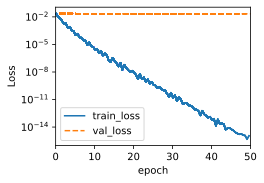

In [16]:
train_scratch(0)    #lambd is 0

### Train with Regularization

L2 norm of w: 0.0004522868257481605


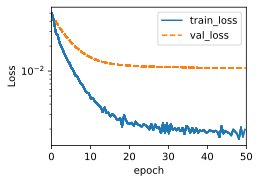

In [17]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)
train_scratch(3)

### Concise implementation

In [ ]:
class WeightDecay(d2l.LinearRegression):
    
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        # note: both LR and weight decay are set here in th eoptimizer!
        return torch.optim.SGD([ 
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

## Exercises

### Ex.1 Try to improve this learning problem by:
- Changing LR 
- Changing $\lambda$
- Increasing the number of epochs
- Simulating more data

### Ex. 2 Try to use an L1 regularization

What would the update equations look like if instead of $∥w∥^2$ we used $\sum_𝑖|𝑤_𝑖|$ as our penalty of choice (l1 regularization)?